# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
### Group 2: Garrett Eickelberg, Kishore Anekalla, Yikuan Li

In [141]:
#libraries
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random


from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [142]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password:········
time: 5.81 s


In [205]:
#initializing the dataframes. 
final_events_df = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_events_df_04-16-18.csv', index_col=0)
ABrx_16sterile_ntnul = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/ABrx_16sterile_ntnul_04-16-18.csv', index_col=0)
ptinfo_ICUsterile_16 = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/ptinfo_ICUsterile_16_04-16-18.csv', index_col=0)
ptinfo_ICUsterile_16_pt = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/ptinfo_ICUsterile_pt_16_04-16-18.csv', index_col=0)
ABrx_16sterile_ntnul_pts = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/ABrx_16sterile_ntnul_pts_04-16-18.csv', index_col=0)

ABrx_16sterile_ntnul_pts = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/sterile_pt_df3_4-16-18.csv', index_col=0)

ABrx_merged_16sterile_ntnul=ABrx_16sterile_ntnul

#dictionary
#final_events_df: result of merger between event rows of INPUTEVENTS/CHARTEVENTS_MV for patients who are 16yo+. 
#ABrx_merged_16sterile_ntnul: result of merger between event rows of Rx after curating for AB for patients who are 16yo+. 
#all rows are an hadm_id associated with a sterile culture that is associated with an antiboitic and is during the patient's icu stay window
 

#ptinfo_ICUsterile_16: this is all the hospital and icu admission and patient data for patients >=16yo, 
#with a sterile culture associated with hadm_id that occured during icu timewindow
#ABrx_16sterile_ntnul_pts= patients list in ABrx_16sterile_ntnul



/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 3.52 s


time: 7.4 ms


In [203]:
ABrx_16sterile_ntnul.head()

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,last_wardid,chartdate,charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,first_sterile_date,culture_count,pt_ab_db
0,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,52,2182-11-29 00:00:00,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00.000000000,2182-11-12 01:50:00,85,cv_ab
1,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,NaN,...,52,2182-11-29 00:00:00,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00.000000000,2182-11-12 01:50:00,85,cv_ab
2,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,NaN,...,52,2182-11-29 00:00:00,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00.000000000,2182-11-12 01:50:00,85,cv_ab
3,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,NaN,...,52,2182-11-29 00:00:00,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00.000000000,2182-11-12 01:50:00,85,cv_ab
4,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,NaN,...,52,2182-11-29 00:00:00,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00.000000000,2182-11-12 01:50:00,85,cv_ab


time: 89.8 ms


# next steps:

data cleaning/cohort selection:

    1)filter cohort to only patients who have sterile culture, antibiotic administration within 24 hours and ICU stay >1 day.
    2)add # of consecutive days of antibiotic dose for each patient

model selection:

    1)import clinical data and build simple logit model
    2)use more sophisticated data mining to improve AUC

Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


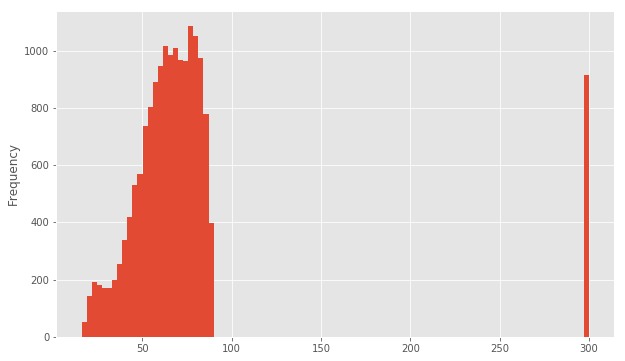

In [221]:
#age of pt in Rx
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul_pts['first_admit_age'].sort_values(ascending=True).plot.hist(100)


# ROTATION PROJECT
so it looks like th


4-6-18:  
from mimiciii team: “Because the table actually contains each instance of the prescribed antibiotics for all the patients - not just the names of the antibiotics. So after you have all the drugs in PRESCRIPTIONS which are antibiotics, you can query for them to get all prescribed antibiotics for a patient.”


this means we can potentially just use the prescriptions table for cohort selection? Makes me wonder why we didn't use this initially? did we think this wasn't comprehensive? 



#todo 4/9/18



mv       9730
cv       8229
cv&mv    1415
both       62
total:   19436 : have sterile culture, >16yo, been rx an AB. 

vs our combined cv/mv: 13713
print(t1),print(t2),print(t3),print(t4)


look at the 5000 pts we didn't capture, and look at which ab they are prescribed. 
need to check: are these antibacterials?



look at our previous final event list, how do we define when AB usage stopped? relook at notes. 
xxx- we were going to use consecutive events to define timeframe.


randomly select ~20 pts, and compare timeings between prescription table and events table. 
this is inleu of boxplot.


for cohort

redo the cv/mv coding but on prescription ab table so its only patients who have antibiotics in one, other, or both.

as long as our pt selection is close to RX table.


##4/11/18

found that the ABrx table has some prescriptions for people that don't have an icu stay. these need to get filtered out. numbers need to get regenerated


#todo after genetics class 4/11:
#3) investigate 20 random false pos/neg patients

In [206]:
#task1
#look at the x pts we not captured in either/both rx and event, and look at which ab they are prescribed.
#need to check: are these antibacterials?


def rx_event_random_sample_fxn(event,rx):
    event_pt_list= list(event['subject_id'].unique())
    rx_pt_list = list(rx['subject_id'].unique())
    pt_not_captured_in_event = list(set(rx_pt_list)-set(event_pt_list))
    pt_not_captured_in_rx = list(set(event_pt_list)-set(rx_pt_list))

    #defining patients not captured in events and rx (false positives and false negs)
    print(len(pt_not_captured_in_event),  'pt in rx not in events')
    print(len(pt_not_captured_in_rx), 'pt in events not in rx' )

    print(len(rx_pt_list), "pt in rx")
    print(len(event_pt_list), 'pt in event')
    print(len(rx_pt_list)-len(event_pt_list), '# of patient difference between event and rx. this is difference in first 2' )

    random.seed(a=4112018)
    rnd_pt_not_captured_in_event = list(random.sample(pt_not_captured_in_event, 20))
    rnd_pt_not_captured_in_rx = list(random.sample(pt_not_captured_in_rx, 20))
    return(rnd_pt_not_captured_in_event, rnd_pt_not_captured_in_rx)

rx_event_random_sample_fxn(final_events_df, ABrx_merged_16sterile_ntnul)
#rnd_pt_not_captured_in_event output
#rnd_pt_not_captured_in_rx output


4919 pt in rx not in events
769 pt in events not in rx
14903 pt in rx
10753 pt in event
4150 # of patient difference between event and rx. this is difference in first 2


([26984,
  10032,
  17773,
  5740,
  23840,
  27810,
  26560,
  3924,
  4576,
  79038,
  3253,
  71808,
  11993,
  16756,
  5578,
  24571,
  89906,
  19297,
  2850,
  15759],
 [4754,
  91079,
  75576,
  15048,
  497,
  4602,
  20804,
  6042,
  65412,
  85195,
  17485,
  9664,
  19016,
  28365,
  7605,
  24807,
  26043,
  77053,
  15055,
  71821])

time: 35.4 ms


In [165]:
length_of_stay.head()

NameError: name 'length_of_stay' is not defined

time: 6.64 ms


7256 pt in rx not in events
1126 pt in events not in rx
19843
13713
6130 # of patient difference between event and rx. this is difference in first 2


reinitialized:
6943 pt in rx not in events
1258 pt in events not in rx
19398 pt in rx
13713 pt in event
5685 # of patient difference between event and rx. this is difference in first 2

In [207]:
#looking in events for patients not captured in prescription
pt_not_captured_in_rx_df =final_events_df.loc[final_events_df.loc[:,'subject_id'].isin(pt_not_captured_in_rx),:]
pt_not_captured_in_rx_df.loc[pt_not_captured_in_rx_df.loc[:,'subject_id'].isin(rnd_pt_not_captured_in_rx),:]

,row_id,subject_id,charttime,itemid,icustay_id,hadm_id,storetime,cgid,value,valuenum,endtime,statusdescription,cancelreason,ordercategorydescription,linkorderid,label
1753,40979728,1227,2116-08-15 02:30:00,855,212223.0,135349,2116-08-15 05:57:00,15331.0,9.5,9.5,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8359,69606322,6861,2108-07-12 19:20:00,856,208076.0,105535,2108-07-12 20:16:00,15331.0,8.8,8.8,NaN,NaN,NaN,NaN,NaN,Vancomycin/Trough
8360,69606368,6861,2108-07-12 21:00:00,854,208076.0,105535,2108-07-12 23:19:00,15331.0,26.7,26.7,NaN,NaN,NaN,NaN,NaN,Vancomycin/Peak
8361,69607320,6861,2108-07-14 03:51:00,855,208076.0,105535,2108-07-14 05:00:00,15331.0,17,17.0,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8579,70198299,6960,2120-11-08 15:00:00,855,298934.0,178048,2120-11-09 01:06:00,15331.0,no data,NaN,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8580,70199921,6960,2120-11-10 04:59:00,856,298934.0,178048,2120-11-10 10:59:00,15331.0,8.3,8.3,NaN,NaN,NaN,NaN,NaN,Vancomycin/Trough
8581,70200123,6960,2120-11-10 09:07:00,855,298934.0,178048,2120-11-10 12:00:00,15331.0,22.7,22.7,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8582,70214364,6960,2120-12-03 12:00:00,855,243530.0,150938,2120-12-03 22:48:00,15331.0,20.8,20.8,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8583,70214769,6960,2120-12-04 04:00:00,855,243530.0,150938,2120-12-04 08:07:00,15331.0,22.2,22.2,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
8584,70216484,6960,2120-12-08 05:20:00,855,273168.0,150938,2120-12-08 10:48:00,15331.0,40.8,40.8,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random


time: 46.1 ms


writeup pt not in prescriptions:

subject id: 1869
hadm_id: 186017
row_id: 44004540
itemid: 855
label: Vancomycin/Random
start time: 2125-10-12 12:00:00
Patient is not in prescription list. reading his chart note, it sounds like he is on a respirator in bed care, and has bed sores which were treated with antibiotics. not sure why this wouldn't be recorded in RX table, but this patient was already in ICU before rx antibiotics, so this pt isn't compatable with our study anyway.

#1
subject id: 3
hadm_id: 118936
row_id: 34307312
itemid: 855

this patient has been given vancomysin, and yet is not in PRESCRIPTIONS table, but is in the icu database. this patient is from CV. IDK what to make of this.
 1.  Vancomycin 1 g intravenously q.24h. for a level of less
than 15 (started on [**2101-10-4**]).

The patient was started on
gentamicin and piperacillin/tazobactam in addition to the
levofloxacin, metronidazole, and vancomycin he was already
taking for right lower extremity cellulitis prior to
admission for empiric coverage of a presumed gram-negative
urosepsis, and he was aggressively hydrated with intravenous
fluids.

On [**2101-10-21**], his levofloxacin and metronidazole was
discontinued, and he was started on fluconazole given the
growth of yeast on urine culture.  He was taken off of
gentamicin on hospital day three, and his fluconazole was
discontinued on hospital day five (as per the Infectious
Disease Service).  He was taken off of vancomycin on
[**2101-10-28**], and his piperacillin/tazobactam was
discontinued on [**2101-10-29**].

...he was already on ab. what to do about this?


#2
subject_id = 195
hadm_id = 118936

this patient is in both chartevents and inputevents_mv. in chartevents they have an itemid=855, which is vancomysin. 
it was given over 3.5 days, 12/12, 12/13, 12/14, 12/14. 
charttime= 2167-12-12.  can't figure out why she's not in prescriptions. 



In [21]:
#looking in prescriptions for patients not selected that were selected in events
pt_not_captured_in_event_df = ABrx__16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'subject_id'].isin(pt_not_captured_in_event),:]
pt_not_captured_in_event_df.loc[pt_not_captured_in_event_df.loc[:,'pt_ab_db']=='mv_ab',:]

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,form_unit_disp,route,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db
1493,1474783,24656,157923,235199,2167-12-19,2167-12-19,MAIN,Vancomycin,NaN,NaN,...,BAG,IV,1807508,True,2111-07-17,M,2163-09-06 16:20:00,52.14,metavision,mv_ab
1494,1474785,24656,157923,235199,2167-12-19,2167-12-22,MAIN,Vancomycin,NaN,NaN,...,VIAL,IV,1807516,True,2111-07-17,M,2163-09-06 16:20:00,52.14,metavision,mv_ab
1721,1394191,26027,159497,204624,2206-02-07,2206-02-10,MAIN,Bacitracin Ointment,Bacitracin Ointment,Bacitracin Ointment,...,TUBE,TP,1366116,True,2166-07-13,M,2201-01-21 05:52:00,34.53,metavision,mv_ab
2019,62916,26220,196422,277119,2150-04-12,2150-04-16,MAIN,Azithromycin,Azithromycin,Azithromycin,...,TAB,PO,308460,True,2078-04-30,F,2143-06-26 08:00:00,65.15,metavision,mv_ab
2601,1396915,26932,106260,257552,2184-09-27,2184-09-27,MAIN,Vancomycin,NaN,NaN,...,BAG,IV,1807508,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab
2602,1396916,26932,106260,257552,2184-09-27,2184-09-27,MAIN,Piperacillin-Tazobactam,NaN,NaN,...,BAG,IV,1659134,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab
2603,1396918,26932,106260,257552,2184-09-27,2184-09-28,MAIN,CefePIME,NaN,NaN,...,mg,IV,1665093,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab
2604,1396921,26932,106260,257552,2184-09-28,2184-09-29,MAIN,Vancomycin,NaN,NaN,...,BAG,IV,1807508,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab
2605,1396925,26932,106260,257552,2184-09-30,2184-10-01,MAIN,Piperacillin-Tazobactam,NaN,NaN,...,BAG,IV,1659151,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab
2606,1396926,26932,106260,257552,2184-09-30,2184-10-03,MAIN,Piperacillin-Tazobactam,NaN,NaN,...,BAG,IV,1659134,True,2105-12-15,F,2179-08-17 14:41:00,73.67,metavision,mv_ab


In [22]:
ABrx_merged_16sterile_ntnul_pts.loc[ABrx_merged_16sterile_ntnul_pts.loc[:,'subject_id'].isin(pt_not_captured_in_event),:]['pt_ab_db'].value_counts()
#breakdown of db source for pt with ab who i didn't capture in my algorithm. 

cv_ab              4036
mv_ab               649
cv/mv_ab             32
both_marking_ab      11
Name: pt_ab_db, dtype: int64



summary:
subject_id: 24942
label: vancomycin HCL
datasource: cv
Hadm_id:    178112
starttime 2159-11-08
I cant find any record of vancomycin perscribed to this pt


subject_id: 24656
hadm_id: 157923
icustay_id: 235199
label: vancomysin

prescription table lists vancomysin being prescribed on 2167-12-19, with the same enddate. was admitted 2167-10-19

chart says (under chemistry, which is odd): 
[**2167-12-19**] 07:40AM    1.5
ADDED ON @ 1045AM
ANTIBIOTICS Vanco

other part of note says: Patient with febrile neutropenia(drops counts on
immunosuppression), received 1 dose of neupogen and 4 days of
vanc/ceftaz
Patient defervesed but no source was idenitified.
CMV VL neg and EBV VL pending upon discharge. Blood, urine
cultures with no growth. 


OHHHh this patient was likely not in the icu anymore when rx antibiotics. they were discharged from the icu on 2167-12-18, but form hospital on 12-23. looks like they transfered her from operating room to ICU . 

On postoperative day seven the patient began to complain of
increasing nausea as well as diarrhea.  Stools were sent at
that time for C.  diff and she was begun on empiric Flagyl.
The following morning the patient had a white count of
34,000.  She was pan cultured and had abdominal films done at
that time.  General surgery was consulted.  The General
surgery service felt the patient had a toxic megacolon.  She
was brought to the Operating Room where she underwent a
partial colectomy with ileostomy and as well as a
cholecystectomy, following which the patient was transferred
back to the Cardiothoracic Intensive Care Unit..

She
spent four days in the Intensive Care Unit following her
abdominal surgery, and was then transferred to the floor for
continuing postoperative care.


**** overall this is a very confusing case where there is contradictory info or important date info omitted throughout their chart. it seems like they may have been transfered to the icu. the vancomysin sounds like it was an older prescription for his surgery, which occured before 2167, whereas the 2167 visit was due to diabetes and had no signs of infecton or rx of antibiotic rx. This patient shouldn't be included



summary:
subject_id: 26027
label: Bacitracin Ointment  !!!topical antibiotic, not useful for this study. 
datasource: mv
Hadm_id:    159497

*** do not include

summary:
subject_id: 26220
label: Azithromycin
datasource: mv
Hadm_id:    196422
icustay_id: 204624
startdate: 2150-04-12

patient appears to have been given azithromycin in the icu on 04-12, however this is not listed in any chartevents or inputevents_mv so there would have been no way to capture this. confired by reading chartnote and looking at prescription table. 

In [ ]:
#summary of manual lookup of pts not captured in events or rx, 
#out of 10 manual lookups, only one of the patients (26220) had somthing that may have been usable for our study.
#the rest of them either were topical antibioitcs, came in while on antibiotics and were continued, or were potentially accidental entries.


In [257]:
##4/12/18:

#1) need to relook up work i did on when pt was admitted to icu, 
#and match up the first antibiotic of each kind for each patient.
-done

#2) compare time between first antiboitic time in event table and start time in prescription table. 


#3) write script to count consecutive ab of anytype for each event pt

#4) patient selection: do patients have sterile culture within 24 hour of their first ab dose?
    #a) first identify first antibiotic date associated with the antiboitic hadm id's 

# after all reinitialized this is where to start out again

In [194]:
#this cell should be obsolete now, after my fortifying of the cohort generation notebook

# #ABrx_merged_16sterile_ntnul = pd.merge(ABrx_merged_16sterile_ntnul, testframe, left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

# set(list(sterile_pt_df3)).intersection(set(list(ABrx_merged_16sterile_ntnul))) #hadm, row_id, subject_id
# set(list(sterile_pt_df3)).intersection(set(list(final_events_df)))# charttime, hadm, row_id, subject_id


# ABrx_merged_16sterile_ntnul = pd.merge(ABrx_merged_16sterile_ntnul, sterile_pt_df3, left_on= 'hadm_id', right_on='hadm_id', how = 'left')

# #these 2 lines should be obsolete now, after my fortifying of the cohort generation notebook

# #final_events_df = pd.merge(final_events_df, sterile_pt_df2[['hadm_id','first_sterile_date','hadm_dates_range', 'culture_count']], left_on= 'hadm_id', right_on='hadm_id', how = 'left')
# #ABrx_merged_16sterile_ntnul = pd.merge(ABrx_merged_16sterile_ntnul, sterile_pt_df2[['hadm_id','first_sterile_date','hadm_dates_range', 'culture_count']], left_on= 'hadm_id', right_on='hadm_id', how = 'left')


{'charttime', 'hadm_id', 'row_id', 'subject_id'}

time: 3.72 ms


In [103]:
# #run after annotating time delta on ABrx for first sterile date per hadm_id on event and rx.
# pd.DataFrame(final_events_df).to_csv('final_events_df_04-16-18.csv')
# pd.DataFrame(ABrx_merged_16sterile_ntnul).to_csv('ABrx_merged_16sterile_ntnul_04-16-18.csv')

In [208]:
#2- compare time between rx and events lists


#final_overlap_pts = final patients in both datasets. who are 16yo+, have sterile cultures associated with antiboitics (hadm_id).



#final_events_pt_list= list(final_events_df.loc[final_events_df.loc[:,'first_ab_date']!= 0, "subject_id"].unique())
final_events_pt_list = list(final_events_df['subject_id'].unique())
final_abrx_pt_list = list(ABrx_merged_16sterile_ntnul['subject_id'].unique())

#final_overlap_pts = [x for x in (final_events_pt_list and final_abrx_pt_list)]
final_overlap_pts= set(final_events_pt_list).intersection(set(final_abrx_pt_list))
print(len(final_overlap_pts)) #11735 patients that overlap between Rx and events

#random sample to compare. 
random_overlap_pts = list(random.sample(final_overlap_pts, 20)) #went from ~11,000 to 12,455 after adding in new rx rows.

9984
time: 13.4 ms


In [49]:
event_rnd=final_events_df.loc[final_events_df.loc[:,'subject_id'].isin(random_overlap_pts), :].sort_values(by=['subject_id','charttime'])
#event_rnd
event_rnd.loc[event_rnd.loc[:,"subject_id"]==8532,:]

,row_id,subject_id,charttime,itemid,icustay_id,hadm_id,storetime,cgid,value,valuenum,endtime,statusdescription,cancelreason,ordercategorydescription,linkorderid,label,first_sterile_date
11018,1217629,8532,2129-12-25 14:28:00,225884,282142.0,156020,2129-12-25 14:28:00,NaN,NaN,NaN,2129-12-25 14:29:00,FinishedRunning,0.0,Drug Push,5157184.0,Metronidazole,2129-12-23 16:50:00
11019,1217642,8532,2129-12-25 16:26:00,225798,282142.0,156020,2129-12-25 16:26:00,NaN,NaN,NaN,2129-12-25 16:27:00,FinishedRunning,0.0,Non Iv Meds,7636964.0,Vancomycin,2129-12-23 16:50:00
11020,1217619,8532,2129-12-25 20:23:00,225798,282142.0,156020,2129-12-25 20:24:00,NaN,NaN,NaN,2129-12-25 20:24:00,FinishedRunning,0.0,Non Iv Meds,3951688.0,Vancomycin,2129-12-23 16:50:00
11021,1217608,8532,2129-12-25 21:48:00,225884,282142.0,156020,2129-12-25 21:49:00,NaN,NaN,NaN,2129-12-25 21:49:00,FinishedRunning,0.0,Drug Push,960518.0,Metronidazole,2129-12-23 16:50:00
11022,1529767,8532,2130-05-07 08:14:00,225798,211727.0,153370,2130-05-07 08:14:00,NaN,NaN,NaN,2130-05-07 08:15:00,FinishedRunning,0.0,Drug Push,9644908.0,Vancomycin,2129-12-23 16:50:00
11023,1529752,8532,2130-05-07 14:21:00,225855,211727.0,153370,2130-05-07 14:23:00,NaN,NaN,NaN,2130-05-07 14:22:00,FinishedRunning,0.0,Drug Push,49547.0,Ceftriaxone,2129-12-23 16:50:00
11024,1529754,8532,2130-05-07 20:07:00,225798,211727.0,153370,2130-05-07 20:07:00,NaN,NaN,NaN,2130-05-07 20:08:00,FinishedRunning,0.0,Drug Push,227744.0,Vancomycin,2129-12-23 16:50:00
11025,1529756,8532,2130-05-08 08:36:00,225798,211727.0,153370,2130-05-08 08:36:00,NaN,NaN,NaN,2130-05-08 08:37:00,FinishedRunning,0.0,Drug Push,919820.0,Vancomycin,2129-12-23 16:50:00
11026,2387339,8532,2131-04-02 00:37:00,225855,214991.0,122585,2131-04-02 00:37:00,NaN,NaN,NaN,2131-04-02 00:38:00,FinishedRunning,0.0,Drug Push,3869220.0,Ceftriaxone,2129-12-23 16:50:00
11027,2387348,8532,2131-04-02 02:54:00,225798,214991.0,122585,2131-04-02 02:54:00,NaN,NaN,NaN,2131-04-02 02:55:00,FinishedRunning,0.0,Drug Push,6212879.0,Vancomycin,2129-12-23 16:50:00


In [50]:
AB_rnd= ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'subject_id'].isin(random_overlap_pts), :].sort_values(by=['subject_id','startdate'])
AB_rnd.loc[AB_rnd.loc[:,"subject_id"]==8532,:]

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,route,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,first_sterile_date
97472,190987,8532,134938,272584,2123-07-22,2123-07-24,MAIN,Vancomycin HCl,NaN,NaN,...,IV,NaN,False,1823-07-20,F,2123-07-20 16:48:00,300.0,carevue,cv/mv_ab,2123-07-28 18:00:00
97480,191550,8532,156020,282142,2129-12-25,2129-12-26,MAIN,MetRONIDAZOLE (FLagyl),NaN,NaN,...,IV,311683,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97481,191865,8532,156020,282142,2129-12-26,2129-12-29,MAIN,MetRONIDAZOLE (FLagyl),MetRONIDAZOLE (FLagyl),MetRONIDAZOLE (FLagyl),...,PO/NG,NaN,False,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97474,185927,8532,153370,211727,2130-05-07,2130-05-07,MAIN,Levofloxacin,Levofloxacin,Levofloxacin,...,PO/NG,NaN,False,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97475,185948,8532,153370,211727,2130-05-07,2130-05-08,MAIN,Vancomycin,NaN,NaN,...,IV,1807516,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97476,185949,8532,153370,211727,2130-05-07,2130-05-08,MAIN,CeftriaXONE,NaN,NaN,...,IV,1665021,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97473,185942,8532,153370,211727,2130-05-08,2130-05-10,MAIN,Levofloxacin,Levofloxacin,Levofloxacin,...,PO/NG,NaN,False,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97477,186119,8532,122585,214991,2131-04-02,2131-04-03,MAIN,Vancomycin,NaN,NaN,...,IV,1807508,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97478,185952,8532,122585,214991,2131-04-02,2131-04-06,MAIN,Levofloxacin,Levofloxacin,Levofloxacin,...,PO,211815,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00
97479,186120,8532,122585,214991,2131-04-04,2131-04-05,MAIN,Vancomycin,NaN,NaN,...,IV,1807508,True,1823-07-20,F,2123-07-20 16:48:00,300.0,metavision,cv/mv_ab,2123-07-28 18:00:00


In [216]:
compare_table=0
compare_table = pd.DataFrame({
    'subject_id': []
    ,'first date in rx': [],
    'ab name in rx': [],
    'first date in event': [],
     'ab name in event': [],
     'date delta': []}, columns=[
    'subject_id','first date in rx', 'ab name in rx','first date in event','ab name in event','date delta'])

compare_table['subject_id']= list(final_overlap_pts)
#random_overlap_pts
#final_overlap_pts

time: 11.1 ms


In [218]:
len(final_overlap_pts)


9984

time: 1.66 ms


In [219]:
#try to populate table

for element in list(compare_table['subject_id']):
    compare_table.loc[compare_table.loc[:,'subject_id']==element,'first date in event'] = min(final_events_df.loc[final_events_df.loc[:,'subject_id']==element, :]['charttime'])
    compare_table.loc[compare_table.loc[:,'subject_id']==element,'first date in rx'] = min(ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'subject_id']==element, :]['startdate'])
    compare_table.loc[compare_table.loc[:,'subject_id']==element,'ab name in event'] = min(final_events_df.loc[final_events_df.loc[:,'subject_id']==element, :]['label'])
    compare_table.loc[compare_table.loc[:,'subject_id']==element,'ab name in rx'] = min(ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'subject_id']==element, :]['drug'])

time: 2min 19s


In [213]:
compare_table.head()

compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])
compare_table['first date in event'] = compare_table['first date in event'].dt.strftime('%Y-%m-%d 00:00:00')
compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])


compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])
compare_table['first date in rx']= compare_table['first date in rx'].dt.strftime('%Y-%m-%d 00:00:00')
compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])

compare_table.head()

compare_table2= compare_table

compare_table2['date delta']= compare_table2['first date in rx']-compare_table2['first date in event']



time: 16.7 ms


In [214]:
compare_table2

,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta
0,85535,2197-01-30,CefazoLIN,2197-01-30,Cefazolin,0 days
1,1293,2127-07-10,Vancomycin HCl,2127-07-10,Vancomycin/Random,0 days
2,74253,2194-12-22,CefePIME,2194-12-22,Ampicillin,0 days
3,9736,2190-04-11,CefazoLIN,2190-04-17,Vancomycin/Random,-6 days
4,13558,2141-02-16,Ampicillin Sodium,2141-02-17,Vancomycin/Random,-1 days
5,72202,2187-12-18,CefazoLIN,2187-12-18,Cefazolin,0 days
6,24477,2195-10-20,Ciprofloxacin HCl,2195-10-19,Cefazolin,1 days
7,27742,2126-11-22,Piperacillin-Tazobactam Na,2126-11-23,Vancomycin/Random,-1 days
8,50832,2118-09-05,CeftriaXONE,2118-09-04,Azithromycin,1 days
9,23473,2151-03-25,Nafcillin,2151-03-24,Vancomycin/Random,1 days


time: 13.6 ms


In [48]:
compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])
#compare_table['first date in event'] = compare_table['first date in event'].dt.strftime('%Y-%m-%d')

compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])
#compare_table['first date in rx']= compare_table['first date in rx'].dt.strftime('%Y-%m-%d')

#compare_table['date delta']= compare_table['first date in rx'].tolist() - compare_table['first date in event'].tolist()
#df_test['Difference'] = df_test['First_Date'].sub(df_test['Second Date'], axis=0)
#compare_table['date delta'] = compare_table['first date in rx'].sub(compare_table['first date in event'], axis=0)
#compare_table['first date in event'].dt.strftime('%Y-%m-%d')

for element in range(len(compare_table)):
    compare_table.iloc[element,5]= pd.Timedelta(compare_table.iloc[element,1]-compare_table.iloc[element,3], unit='d')
    #print(element)
compare_table

#subject 20236 and 15644 suggest that the hadm id isnt conserved over every one.

,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta
0,51586,2132-09-18,Levofloxacin,2132-09-18 08:00:00,Levofloxacin,-1 days +16:00:00
1,5729,2102-03-11,Levofloxacin,2102-03-12 19:54:00,Vancomycin/Random,-2 days +04:06:00
2,61735,2180-10-31,Azithromycin,2180-10-31 13:30:00,Azithromycin,-1 days +10:30:00
3,8532,2123-07-22,CeftriaXONE,2129-12-25 14:28:00,Ceftriaxone,-2349 days +09:32:00
4,10941,2126-06-21,Ceftazidime,2126-06-23 05:27:00,Vancomycin/Random,-3 days +18:33:00
5,46228,2183-11-27,Amoxicillin-Clavulanic Acid,2183-11-27 19:19:00,Ceftriaxone,-1 days +04:41:00
6,47460,2172-08-01,CefazoLIN,2172-08-01 14:59:00,Cefazolin,-1 days +09:01:00
7,95208,2123-10-19,Ciprofloxacin HCl,2123-10-18 22:43:00,Bactrim (SMX/TMP),0 days 01:17:00
8,25111,2147-01-07,Levofloxacin,2148-04-10 10:00:00,Vancomycin/Random,-460 days +14:00:00
9,56634,2105-12-17,CefePIME,2105-12-07 22:10:00,Cefazolin,9 days 01:50:00


In [220]:
final_events_df.loc[final_events_df.loc[:,'subject_id']==5729,:]

,row_id,subject_id,charttime,itemid,icustay_id,hadm_id,storetime,cgid,value,valuenum,endtime,statusdescription,cancelreason,ordercategorydescription,linkorderid,label
6973,63772911,5729,2102-03-12 19:54:00,855,286565.0,162647,2102-03-13 01:23:00,15331.0,6.6,6.6,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random
6974,63775897,5729,2102-03-16 00:14:00,856,286565.0,162647,2102-03-16 04:09:00,15331.0,13,13.0,NaN,NaN,NaN,NaN,NaN,Vancomycin/Trough
6975,63776995,5729,2102-03-23 03:56:00,855,260754.0,162647,2102-03-23 06:02:00,15331.0,20.8,20.8,NaN,NaN,NaN,NaN,NaN,Vancomycin/Random


time: 18.6 ms


In [290]:
final_events_df.loc[final_events_df.loc[:,'subject_id']==20236,:].sort_values('charttime').head()


,row_id,subject_id,charttime,itemid,icustay_id,hadm_id,storetime,cgid,value,valuenum,endtime,statusdescription,cancelreason,ordercategorydescription,linkorderid,label,first_sterile_date
25478,3316081,20236,2136-05-16 17:00:00,225851,295481.0,151904,2136-05-16 17:14:00,NaN,NaN,NaN,2136-05-16 17:01:00,FinishedRunning,0.0,Drug Push,7840450.0,Cefepime,2136-05-16 06:10:00
25479,3316056,20236,2136-05-16 17:00:00,225851,295481.0,151904,2136-05-16 17:14:00,NaN,NaN,NaN,2136-05-16 17:01:00,Rewritten,2.0,Drug Push,981146.0,Cefepime,2136-05-16 06:10:00
25480,3316072,20236,2136-05-17 13:42:00,225798,295481.0,151904,2136-05-17 13:42:00,NaN,NaN,NaN,2136-05-17 13:43:00,FinishedRunning,0.0,Drug Push,6701786.0,Vancomycin,2136-05-16 06:10:00
25481,3316060,20236,2136-05-17 19:21:00,225851,295481.0,151904,2136-05-18 02:21:00,NaN,NaN,NaN,2136-05-17 19:22:00,FinishedRunning,0.0,Drug Push,1761128.0,Cefepime,2136-05-16 06:10:00
25482,3316067,20236,2136-05-17 20:45:00,225798,295481.0,151904,2136-05-18 02:21:00,NaN,NaN,NaN,2136-05-17 20:46:00,FinishedRunning,0.0,Drug Push,4542311.0,Vancomycin,2136-05-16 06:10:00


In [291]:
ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'subject_id']==20236,:].sort_values('startdate').head()

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,form_unit_disp,route,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db
92249,2789778,20236,154430,241146,2130-09-03,2130-09-08,MAIN,Bacitracin Ointment,Bacitracin Ointment,Bacitracin Ointment,...,TUBE,TP,1366116,True,2090-05-12,M,2130-09-02 21:45:00,40.31,carevue,cv/mv_ab
92250,2789762,20236,154430,241146,2130-09-03,2130-09-04,MAIN,CefazoLIN,NaN,NaN,...,BAG,IV,1665050,True,2090-05-12,M,2130-09-02 21:45:00,40.31,carevue,cv/mv_ab
92237,2791202,20236,151904,295481,2136-05-16,2136-05-18,MAIN,CefePIME,NaN,NaN,...,mL,IV,1665093,True,2090-05-12,M,2130-09-02 21:45:00,40.31,metavision,cv/mv_ab
92238,2791212,20236,151904,295481,2136-05-17,2136-05-18,MAIN,Vancomycin,NaN,NaN,...,BAG,IV,1807508,True,2090-05-12,M,2130-09-02 21:45:00,40.31,metavision,cv/mv_ab
92239,2791213,20236,151904,295481,2136-05-17,2136-05-19,MAIN,Vancomycin,NaN,NaN,...,BAG,IV,1807508,True,2090-05-12,M,2130-09-02 21:45:00,40.31,metavision,cv/mv_ab


In [152]:
compare_table['first date in rx'] = min(
    final_events_df.loc[final_events_df.loc[:,'subject_id'].isin(random_overlap_pts), :].sort_values(by=['subject_id','charttime'])['charttime'])

compare_table

In [55]:
compare_table

,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta
0,51586,2132-09-18,Levofloxacin,2132-09-18 08:00:00,Levofloxacin,-1 days +16:00:00
1,5729,2102-03-11,Levofloxacin,2102-03-12 19:54:00,Vancomycin/Random,-2 days +04:06:00
2,61735,2180-10-31,Azithromycin,2180-10-31 13:30:00,Azithromycin,-1 days +10:30:00
3,8532,2123-07-22,CeftriaXONE,2129-12-25 14:28:00,Ceftriaxone,-2349 days +09:32:00
4,10941,2126-06-21,Ceftazidime,2126-06-23 05:27:00,Vancomycin/Random,-3 days +18:33:00
5,46228,2183-11-27,Amoxicillin-Clavulanic Acid,2183-11-27 19:19:00,Ceftriaxone,-1 days +04:41:00
6,47460,2172-08-01,CefazoLIN,2172-08-01 14:59:00,Cefazolin,-1 days +09:01:00
7,95208,2123-10-19,Ciprofloxacin HCl,2123-10-18 22:43:00,Bactrim (SMX/TMP),0 days 01:17:00
8,25111,2147-01-07,Levofloxacin,2148-04-10 10:00:00,Vancomycin/Random,-460 days +14:00:00
9,56634,2105-12-17,CefePIME,2105-12-07 22:10:00,Cefazolin,9 days 01:50:00


TODO on weekend/monday:  04/13/18:

redo compare table with hadm_id that are overlapped. for the x # of hadm_id that are overlapped we should make a table that looks at the time differential between rx and events. my current table doesn't just look at hadm_id, it looks at first for each pt, which can be conflicting. there are many instances where the chartevents/inputevents tables don't have any mention of ab. 

also should do the same thing but for just rx table and compare the delta between the first sterile culture time and the start time. 

In [21]:
#making an Rxcui and Prescription table that overlap with icustay_id.  

#len(set(fst).intersection(snd))
hadm_overlap= list(set(list(final_events_df['hadm_id'].unique())).intersection( set(list(ABrx_merged_16sterile_ntnul['hadm_id'].unique()))))
final_events_df_hadmoverlap= final_events_df.loc[final_events_df.loc[:,'hadm_id'].isin(hadm_overlap),:]
ABrx_merged_16sterile_ntnul_hadmoverlap= ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'hadm_id'].isin(hadm_overlap),:]



random_overlap_pts = list(random.sample(list(ABrx_merged_16sterile_ntnul_hadmoverlap['subject_id'].unique()), 20)) #N=20
total_overlap_pts= list(ABrx_merged_16sterile_ntnul_hadmoverlap['subject_id'].unique()) #N=12327

In [40]:
print(len(ABrx_merged_16sterile_ntnul['hadm_id'].unique()), #25761 icu stays, 24039 hadm_id
len(final_events_df['hadm_id'].unique()))  #17814 icu stays, 16738 hadm_id

24039 16738


In [41]:
print(len(ABrx_merged_16sterile_ntnul_hadmoverlap['hadm_id'].unique()), #25761 icu stays, 24039 hadm_id
len(final_events_df_hadmoverlap['hadm_id'].unique()))  #17814 icu stays, 16738 hadm_id
#both have 14727 hadm_id. 

14727 14727


In [34]:
len(total_overlap_pts) #12327


,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,first_sterile_date,culture_starttime_delta
0,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,404652.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,27 days 22:10:00
1,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,NaN,...,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,16 days 22:10:00
2,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,NaN,...,239209.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,4 days 22:10:00
3,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,NaN,...,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,4 days 22:10:00
4,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,NaN,...,NaN,False,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,60 days 22:10:00


In [49]:
compare_table=0
compare_table = pd.DataFrame({
    'subject_id': []
    ,'first date in rx': [],
    'ab name in rx': [],
    'first date in event': [],
     'ab name in event': [],
    'hadm_id': [],
     'date delta': []}, columns=[
    'subject_id','first date in rx', 'ab name in rx','first date in event','ab name in event','date delta'])

#compare_table['subject_id']= total_overlap_pts
compare_table['hadm_id']= final_events_df_hadmoverlap['hadm_id'].unique()

In [61]:
#try to populate table

#would be nice to vectorize this

#change this for in list hadm_id and list the subject_id

#changed 'subject_id' everywhere to 'hadm_id'

for element in list(compare_table['hadm_id']):
    compare_table.loc[compare_table.loc[:,'hadm_id']==element,'first date in event'] = min(final_events_df_hadmoverlap.loc[final_events_df_hadmoverlap.loc[:,'hadm_id']==element, :]['charttime'])
    compare_table.loc[compare_table.loc[:,'hadm_id']==element,'first date in rx'] = min(ABrx_merged_16sterile_ntnul_hadmoverlap.loc[ABrx_merged_16sterile_ntnul_hadmoverlap.loc[:,'hadm_id']==element, :]['startdate'])
    compare_table.loc[compare_table.loc[:,'hadm_id']==element,'ab name in event'] = min(final_events_df_hadmoverlap.loc[final_events_df_hadmoverlap.loc[:,'hadm_id']==element, :]['label'])
    compare_table.loc[compare_table.loc[:,'hadm_id']==element,'ab name in rx'] = min(ABrx_merged_16sterile_ntnul_hadmoverlap.loc[ABrx_merged_16sterile_ntnul_hadmoverlap.loc[:,'hadm_id']==element, :]['drug'])
    compare_table.loc[compare_table.loc[:,'hadm_id']==element,'subject_id'] = ABrx_merged_16sterile_ntnul_hadmoverlap.loc[ABrx_merged_16sterile_ntnul_hadmoverlap.loc[:,'hadm_id']==element, :]['subject_id'].unique()
    compare_table.loc[compare_table.loc[:,'subject_id']==element,'hadm_id_event'] = min(final_events_df_hadmoverlap.loc[final_events_df_hadmoverlap.loc[:,'subject_id']==element, :]['hadm_id'])
    #compare_table.loc[compare_table.loc[:,'subject_id']==element,'hadm_id_rx'] = min(ABrx_merged_16sterile_ntnul_hadmoverlap.loc[ABrx_merged_16sterile_ntnul_hadmoverlap.loc[:,'subject_id']==element, :]['hadm_id']

In [64]:
compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])
#compare_table['first date in event'] = compare_table['first date in event'].dt.strftime('%Y-%m-%d')

compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])
#compare_table['first date in rx']= compare_table['first date in rx'].dt.strftime('%Y-%m-%d')

#compare_table['date delta']= compare_table['first date in rx'].tolist() - compare_table['first date in event'].tolist()
#df_test['Difference'] = df_test['First_Date'].sub(df_test['Second Date'], axis=0)
#compare_table['date delta'] = compare_table['first date in rx'].sub(compare_table['first date in event'], axis=0)
#compare_table['first date in event'].dt.strftime('%Y-%m-%d')

for element in range(len(compare_table)):
    compare_table.iloc[element,5]= pd.Timedelta(compare_table.iloc[element,1]-compare_table.iloc[element,3], unit='d')
    #print(element)
compare_table

#subject 20236 and 15644 suggest that the hadm id isnt conserved over every one.
#12327 rows for 12327 overlap patients. 

,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta
0,24915,2182-11-12,Azithromycin,2182-11-20 00:09:00,Vancomycin/Peak,-9 days +23:51:00
1,24922,2164-11-06,Cefepime,2164-10-25 19:55:00,Vancomycin/Peak,11 days 04:05:00
2,24776,2154-11-11,CeftriaXONE,2154-11-11 09:52:00,Ceftriaxone,-1 days +14:08:00
3,24824,2120-05-24,Levofloxacin,2120-05-25 04:51:00,Vancomycin/Random,-2 days +19:09:00
4,24837,2166-04-13,Ampicillin,2166-04-14 04:00:00,Vancomycin/Random,-2 days +20:00:00
5,24785,2167-09-27,Amoxicillin-Clavulanic Acid,2167-09-26 22:00:00,Ceftazidime,0 days 02:00:00
6,24799,2200-09-09,Clindamycin,2200-09-09 01:06:00,Vancomycin/Random,-1 days +22:54:00
7,24675,2132-07-28,Ceftriaxone,2132-07-28 20:30:00,Vancomycin/Random,-1 days +03:30:00
8,24676,2151-08-20,Gentamicin,2151-08-24 10:23:00,Vancomycin/Random,-5 days +13:37:00
9,24846,2124-12-12,Ampicillin-Sulbactam,2124-12-12 04:43:00,Vancomycin (Random),-1 days +19:17:00


In [59]:
##this is a roud about way but wayyyy faster and vectorizes the date deltas. i loose the by hour resolution though.

compare_table.head()

compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])
compare_table['first date in event'] = compare_table['first date in event'].dt.strftime('%Y-%m-%d 00:00:00')
compare_table['first date in event'] = pd.to_datetime(compare_table['first date in event'])


compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])
compare_table['first date in rx']= compare_table['first date in rx'].dt.strftime('%Y-%m-%d 00:00:00')
compare_table['first date in rx'] = pd.to_datetime(compare_table['first date in rx'])

compare_table.head()

compare_table2= compare_table

compare_table2['date delta']= compare_table2['first date in rx']-compare_table2['first date in event']

In [60]:
compare_table2

,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta,hadm_id
0,4.0,2191-03-16,Clindamycin,2191-03-17,Vancomycin/Random,-1 days,185777
1,21.0,2135-01-31,Linezolid,2135-01-31,Vancomycin/Random,0 days,111970
2,36.0,2134-05-12,CeftriaXONE,2134-05-12,Ceftazidime,0 days,165660
3,38.0,2166-08-10,Levofloxacin,2166-08-11,Vancomycin/Random,-1 days,185910
4,41.0,2133-01-03,Clindamycin,2133-01-04,Vancomycin/Random,-1 days,101757
5,68.0,2174-01-12,Vancomycin HCl,2174-01-11,Vancomycin/Random,1 days,108329
6,85.0,2167-07-26,Azithromycin,2167-07-26,Cefepime,0 days,112077
7,96.0,2156-04-06,Ceftazidime,2156-04-13,Vancomycin/Random,-7 days,170324
8,109.0,2140-08-26,Vancomycin,2140-08-27,Vancomycin/Random,-1 days,110668
9,109.0,2141-06-11,Ciprofloxacin HCl,2141-06-11,Ciprofloxacin,0 days,147469


count                       14727
mean     -1 days +09:44:19.849256
std        3 days 10:51:09.400299
min            -81 days +00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max              34 days 00:00:00
Name: date delta, dtype: object

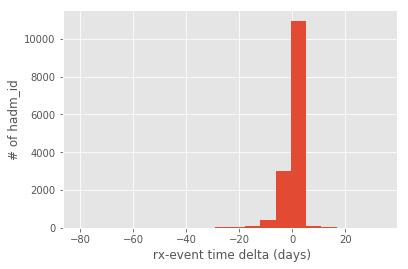

In [58]:
compare_table2['date delta'].describe()

(compare_table2['date delta'] / pd.Timedelta(hours=1)).hist(bins = 20)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' rx-event time delta (days)')
plt.ylabel('# of hadm_id');

compare_table2['date delta'].describe()


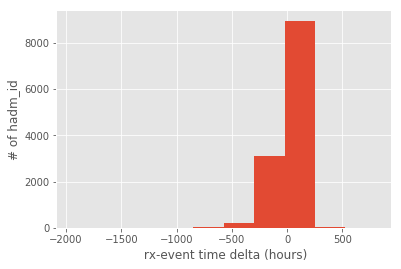

In [89]:
compare_table['date delta'].describe()

(compare_table['date delta'] / pd.Timedelta(hours=1)).hist()#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' rx-event time delta (hours)')
plt.ylabel('# of hadm_id');


In [78]:
#looking at the rows with >5 day difference.

d = timedelta(days=5)

compare_table_gr5= compare_table2.loc[compare_table2.loc[:,'date delta']>=d,:]

# 3298/14727  hadm_id have >=1 day difference. 
# 905/14727 hadm_id have >=2 day difference. 
# 425/14727 hadm_id have >=3 day difference. 
# 151/14727 hadm_id have >=5 day difference.
compare_table_gr5.head()



,subject_id,first date in rx,ab name in rx,first date in event,ab name in event,date delta,hadm_id
176,1106.0,2103-11-08,Levofloxacin,2103-11-03,Levofloxacin,5 days,170024
420,2628.0,2126-01-29,Imipenem-Cilastatin,2126-01-02,Vancomycin/Peak,27 days,105769
528,3267.0,2193-08-27,Gentamicin Sulfate,2193-08-07,Ciprofloxacin,20 days,134370
680,4113.0,2149-04-08,Vancomycin,2149-04-03,Vancomycin,5 days,191180
766,4760.0,2178-10-31,Vancomycin HCl,2178-10-24,Vancomycin/Random,7 days,184259


Subject id: 1106
Date delta: 5days
Hadm_id: 170024
First date in rx: 2103-11-08	
first date in event	2103-11-03	
first_sterile_date= 2103-11-02 14:30:00 ###this is really bizzare, how is this before icu admission?

intime: 2103-11-03 13:06:03 (icustays)
outtime: 2103-11-09 18:37:02 (icustays) 

it appears that the events table may have captured the antibiotics that occured during the icu stay and the Rx may have captured the AB prescription upon discharge. 


In [96]:
final_events_df.loc[final_events_df.loc[:,'hadm_id']==170024, :]


###ok this sql code highlights that my first sterileculture algorithm is off. need to redo.
# """select * FROM mimiciii.microbiologyevents
# WHERE hadm_id =170024 AND
# NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
# NOT lower(spec_type_desc) = 'blood bag fluid'
# AND (lower(spec_type_desc) LIKE '%blood%' 
# OR lower(spec_type_desc) LIKE '%joint%' 
# OR lower(spec_type_desc) LIKE '%urine%' 
# OR lower(spec_type_desc) LIKE  '%csf%'
# OR lower(spec_type_desc) LIKE '%spinal%'
# OR lower(spec_type_desc) LIKE '%pleural%'
# OR lower(spec_type_desc) LIKE '%peritoneal%')
# group by subject_id, row_id
# ORDER BY count(subject_id) DESC


# """" 
#for this hadm_id it should be 2123-11-02 and it was 2103-09-27

#

,row_id,subject_id,charttime,itemid,icustay_id,hadm_id,storetime,cgid,value,valuenum,endtime,statusdescription,cancelreason,ordercategorydescription,linkorderid,label,first_sterile_date
1717,176467,1106,2103-11-03 20:40:00,225883,241570.0,170024,2103-11-03 20:40:00,NaN,NaN,NaN,2103-11-03 20:41:00,FinishedRunning,0.0,Drug Push,4081387.0,Meropenem,2103-11-02 14:30:00
1718,176509,1106,2103-11-03 21:18:00,225879,241570.0,170024,2103-11-03 21:18:00,NaN,NaN,NaN,2103-11-03 21:19:00,FinishedRunning,0.0,Drug Push,5580030.0,Levofloxacin,2103-11-02 14:30:00
1719,176380,1106,2103-11-04 08:00:00,225883,241570.0,170024,2103-11-04 09:44:00,NaN,NaN,NaN,2103-11-04 08:01:00,FinishedRunning,0.0,Drug Push,674898.0,Meropenem,2103-11-02 14:30:00
1720,176403,1106,2103-11-04 20:00:00,225883,241570.0,170024,2103-11-04 19:34:00,NaN,NaN,NaN,2103-11-04 20:01:00,FinishedRunning,0.0,Drug Push,2076026.0,Meropenem,2103-11-02 14:30:00
1721,176462,1106,2103-11-04 20:26:00,225798,241570.0,170024,2103-11-04 20:26:00,NaN,NaN,NaN,2103-11-04 20:27:00,FinishedRunning,0.0,Drug Push,3848805.0,Vancomycin,2103-11-02 14:30:00
1722,176395,1106,2103-11-05 08:00:00,225883,241570.0,170024,2103-11-05 08:00:00,NaN,NaN,NaN,2103-11-05 08:01:00,FinishedRunning,0.0,Drug Push,1778782.0,Meropenem,2103-11-02 14:30:00
1723,176415,1106,2103-11-05 19:00:00,225879,241570.0,170024,2103-11-05 20:30:00,NaN,NaN,NaN,2103-11-05 19:01:00,FinishedRunning,0.0,Drug Push,2443050.0,Levofloxacin,2103-11-02 14:30:00
1724,176382,1106,2103-11-05 20:30:00,225883,241570.0,170024,2103-11-05 23:11:00,NaN,NaN,NaN,2103-11-05 20:31:00,FinishedRunning,0.0,Drug Push,725515.0,Meropenem,2103-11-02 14:30:00
1725,176474,1106,2103-11-06 08:00:00,225883,241570.0,170024,2103-11-06 13:23:00,NaN,NaN,NaN,2103-11-06 08:01:00,FinishedRunning,0.0,Drug Push,4172820.0,Meropenem,2103-11-02 14:30:00
1726,176582,1106,2103-11-06 20:33:00,225883,241570.0,170024,2103-11-07 00:34:00,NaN,NaN,NaN,2103-11-06 20:34:00,FinishedRunning,0.0,Drug Push,8691862.0,Meropenem,2103-11-02 14:30:00


In [102]:
ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'hadm_id']==170024, :]



,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,culture_starttime_delta,first_sterile_date
82975,876852,1106,170024,241570.0,2103-11-08,2103-11-09,MAIN,Vancomycin,NaN,NaN,...,1807508.0,True,2058-07-04,M,2103-09-27 18:02:00,45.23,metavision,mv_ab,41 days 07:55:00,2103-11-02 14:30:00
82976,876076,1106,170024,241570.0,2103-11-09,2103-11-10,MAIN,Levofloxacin,Levofloxacin,Levofloxacin,...,NaN,False,2058-07-04,M,2103-09-27 18:02:00,45.23,metavision,mv_ab,42 days 07:55:00,2103-11-02 14:30:00


not great agreement between rx and prescription. again this is for the same hadm_id. lots of difference between the items prescribed and the times they were prescribed : /. 

now i should do same analysis but between the prescription table and the associated sterile culture.

In [7]:
ABrx_merged_16sterile_ntnul.head()

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,route,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,first_sterile_date
0,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,IV,404652.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00
1,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,NaN,...,IV,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00
2,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,NaN,...,IV,239209.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00
3,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,NaN,...,IV,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00
4,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,NaN,...,IV,NaN,False,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00


In [8]:
#task: find the row for each hadm_id that most closely matches the first sterile culture date in ABrx_merged_16sterile_ntnul. 
#rewrote this code in vectorized manner on 4/16/18. runs much faster,

#doing date delta between hadm_id associated sterile culture and 

def datetime_conversion_fxn(df,col_input):
    slice_obj= df[col_input]
    slice_obj= pd.to_datetime(slice_obj)
    slice_obj.dt.strftime('%Y-%m-%d %H:%M:%S')
    slice_obj= pd.to_datetime(slice_obj)

# ABrx_merged_16sterile_ntnul['startdate'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['startdate'])
# ABrx_merged_16sterile_ntnul['startdate'] = ABrx_merged_16sterile_ntnul_test['startdate'].dt.strftime('%Y-%m-%d %H:%M:%S')
# ABrx_merged_16sterile_ntnul['startdate'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['startdate'])


# ABrx_merged_16sterile_ntnul['first_sterile_date'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['first_sterile_date'])
# ABrx_merged_16sterile_ntnul['first_sterile_date']= ABrx_merged_16sterile_ntnul_test['first_sterile_date'].dt.strftime('%Y-%m-%d %H:%M:%S')
# ABrx_merged_16sterile_ntnul['first_sterile_date'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['first_sterile_date'])

#replaced above 6 lines of code with this
datetime_conversion_fxn(ABrx_merged_16sterile_ntnul,'startdate')
datetime_conversion_fxn(ABrx_merged_16sterile_ntnul,'first_sterile_date')

ABrx_merged_16sterile_ntnul['culture_starttime_delta'] =0 

#for element in range(len(ABrx_merged_16sterile_ntnul)):
#    ABrx_merged_16sterile_ntnul.iloc[element,28]= pd.Timedelta(ABrx_merged_16sterile_ntnul.iloc[element,4]-ABrx_merged_16sterile_ntnul.iloc[element,27], unit='d')


ABrx_merged_16sterile_ntnul['culture_starttime_delta']= ABrx_merged_16sterile_ntnul['startdate']-ABrx_merged_16sterile_ntnul['first_sterile_date']


,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,rxcui,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,first_sterile_date,culture_starttime_delta
0,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,404652.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,27 days 22:10:00
1,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,NaN,...,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,16 days 22:10:00
2,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,NaN,...,239209.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,4 days 22:10:00
3,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,NaN,...,1726216.0,True,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,4 days 22:10:00
4,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,NaN,...,NaN,False,2129-04-20,F,2182-11-11 20:01:00,53.56,carevue,cv_ab,2182-11-12 01:50:00,60 days 22:10:00


0   27 days 22:10:00
1   16 days 22:10:00
2    4 days 22:10:00
3    4 days 22:10:00
4   60 days 22:10:00
Name: date delta, dtype: timedelta64[ns]

In [17]:
#now to select the rows for each hadm id that are closest to the sterile culture date.

#remember the eqn is: antibiotic start date - culture date, so if antibiotic start before culture it should be negative. 

#first fileter on only those which are negative. 
from datetime import timedelta
d = timedelta(days=0)

ABrx_merged_16sterile_ntnul_AB_before_sterile=ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'culture_starttime_delta']<d,:]

len(ABrx_merged_16sterile_ntnul_AB_before_sterile['subject_id'].unique())





7247

In [ ]:
#ABrx_merged_16sterile_ntnul.iloc[1,29]= pd.Timedelta(ABrx_merged_16sterile_ntnul.iloc[1,4]-ABrx_merged_16sterile_ntnul.iloc[1,27], unit='d')



In [72]:
print(max(compare_table['date delta']),min(compare_table['date delta']))


33 days 10:45:00 -82 days +18:30:00


In [69]:
time_delta = pd.to_datetime(compare_table['date delta'].str.strip(), 
                                format='%m/%d/%y %H:%M:%S')

eruption_deltas = eruption_times.diff()


todo 4/16/18

redo sterile culture time algorithm.#done

#check new prescription table compariosn of culture time and start-time. 


filter discrepency tables for >30 discrepency. look at a few examples. which table makes more sense?

also test haadm id vs icustay id vs subject id. 

highlight points in my python notebook, and send to nelson and dr Luo. 


try merging the two tables and selecting the first antibiotic date prior to each sterile culture. 

focus on compiling current results onto the forum and email. 

take screenshots of the jupyter notebook. 


CLEANUP order of jupyter notebook. restructure so it can all be run. 

    make a new clean notebook
    start to wrap things in functions 


In [129]:
#making functions, maybe makes life easier?

def bool_fxn(df,bool_col, bool_value):

def slicing_fxn(df,bool_col, bool_value):

    slice_result=df.loc[df.loc[:,bool_col]==bool_value, :]
    return(slice_result)



In [ ]:
ABrx_merged_16sterile_ntnul.loc[ABrx_merged_16sterile_ntnul.loc[:,'culture_starttime_delta']<d,:]

In [130]:
slicing_fxn(ABrx_merged_16sterile_ntnul,'culture_starttime_delta', d)

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,Antibiotics,dob,gender,first_admittime,first_admit_age,dbsource,pt_ab_db,culture_starttime_delta,first_sterile_date,date delta
4735,2802579,26083,120427,237983.0,2200-08-28,2200-08-29,MAIN,Piperacillin-Tazobactam Na,NaN,NaN,...,True,2116-05-27,M,2200-08-18 22:44:00,84.23,carevue,cv_ab,5 days 00:00:00,2200-08-23,5 days
6257,3256178,26753,102793,244475.0,2186-07-05,2186-07-05,MAIN,Sulfameth/Trimethoprim DS,Sulfameth/Trimethoprim DS,Sulfameth/Trimethoprim DS,...,True,2142-11-12,F,2186-06-30 01:56:00,43.63,carevue,cv_ab,5 days 00:00:00,2186-06-30,5 days
6258,3256177,26753,102793,244475.0,2186-07-05,2186-07-14,MAIN,Azithromycin,Azithromycin,Azithromycin,...,True,2142-11-12,F,2186-06-30 01:56:00,43.63,carevue,cv_ab,5 days 00:00:00,2186-06-30,5 days
9697,3283459,27811,157821,205161.0,2147-10-12,2147-10-13,MAIN,Vancomycin,NaN,NaN,...,True,2094-03-16,M,2147-10-06 17:04:00,53.56,carevue,cv_ab,5 days 00:00:00,2147-10-07,5 days
45047,3844614,61526,197570,290165.0,2129-12-29,2129-12-29,MAIN,Piperacillin-Tazobactam,NaN,NaN,...,True,2104-04-26,M,2129-12-24 04:21:00,25.66,metavision,mv_ab,5 days 00:00:00,2129-12-24,5 days
45048,3844615,61526,197570,290165.0,2129-12-29,2129-12-31,MAIN,Piperacillin-Tazobactam,NaN,NaN,...,True,2104-04-26,M,2129-12-24 04:21:00,25.66,metavision,mv_ab,5 days 00:00:00,2129-12-24,5 days
47574,4098703,65999,126011,262821.0,2179-04-08,2179-04-09,MAIN,Amoxicillin,Amoxicillin,AMOXicillin Oral Susp,...,True,2136-07-18,M,2179-04-03 00:32:00,42.71,metavision,mv_ab,5 days 00:00:00,2179-04-03,5 days
47575,4098704,65999,126011,262821.0,2179-04-08,2179-04-19,MAIN,Clarithromycin,Clarithromycin,Clarithromycin (Suspension),...,True,2136-07-18,M,2179-04-03 00:32:00,42.71,metavision,mv_ab,5 days 00:00:00,2179-04-03,5 days
51647,3826969,69758,119269,206671.0,2179-02-13,2179-02-15,MAIN,Vancomycin,NaN,NaN,...,True,2124-12-09,F,2179-02-08 01:47:00,54.17,metavision,mv_ab,5 days 00:00:00,2179-02-08,5 days
90780,301147,4793,130489,254615.0,2178-03-02,2178-03-04,MAIN,Vancomycin HCl,NaN,NaN,...,False,2124-01-02,F,2178-02-25 01:22:00,54.15,carevue,cv_ab,5 days 00:00:00,2178-02-25,5 days


jupyter tips:

Use joblib for caching output
You thought your neural network for three days and now you are ready to build on top of it. But you forgot to plug your laptop to a power source and it runs out of batteries. So you scream: Why didn’t I pickle!? The answer is: because it is pain in the back. Managing file names, checking if the file exists, saving, loading… What to do instead? Use joblib.

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
@memory.cache
def computation(p1, p2):
    ...
With three lines of code, you get caching of the output of any function. Joblib traces parameters passed to a function, and if the function has been called with the same parameters it returns the return value cached on a disk.

8. Make sections of the notebook self-contained
Make sections of your notebook loosely bound. Use as little global variables as possible. If you wrap your cells in functions and you use joblib for caching, it is really inexpensive to call same code within each section. It’s better than making code reliable on the variables created several cells above.

In general, try to limit the number of cells you have to re-run after the restart to continue on your work.


When you create some utility function, create short tests using assert keyword. For example:

def norm_scale(X, axis=0):
    mx = np.max(X, axis=axis)
    mi = np.min(X, axis=axis)
    epsilon = 10**-32
    return (X — mi) / (np.abs(mi) + mx + epsilon)
norm = norm_scale(X)
assert np.min(norm) >= 0
assert np.max(norm) <= 1

In [138]:
from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)


In [139]:
@memory.cache
def datetime_conversion_fxn(df,col_input):
    slice_obj= df[col_input]
    slice_obj= pd.to_datetime(slice_obj)
    slice_obj.dt.strftime('%Y-%m-%d %H:%M:%S')
    slice_obj= pd.to_datetime(slice_obj)

# ABrx_merged_16sterile_ntnul['startdate'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['startdate'])
# ABrx_merged_16sterile_ntnul['startdate'] = ABrx_merged_16sterile_ntnul_test['startdate'].dt.strftime('%Y-%m-%d %H:%M:%S')
# ABrx_merged_16sterile_ntnul['startdate'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['startdate'])


# ABrx_merged_16sterile_ntnul['first_sterile_date'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['first_sterile_date'])
# ABrx_merged_16sterile_ntnul['first_sterile_date']= ABrx_merged_16sterile_ntnul_test['first_sterile_date'].dt.strftime('%Y-%m-%d %H:%M:%S')
# ABrx_merged_16sterile_ntnul['first_sterile_date'] = pd.to_datetime(ABrx_merged_16sterile_ntnul_test['first_sterile_date'])

#replaced above 6 lines of code with this
datetime_conversion_fxn(ABrx_merged_16sterile_ntnul,'startdate')
datetime_conversion_fxn(ABrx_merged_16sterile_ntnul,'first_sterile_date')

KeyboardInterrupt: 